In [1]:
# Import Optimization Libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# Import General Libraries
import sympy as sym
import numpy as np
from IPython.display import display 

# Create a Concrete Model
model = ConcreteModel()

In [2]:
Nodes = 120
TT = 0.25
Damping_val = 34.7
BB_extend = 160.3
BB_retract = 132.6
BB_force = BB_extend #50

# Nodes
kNodes = 12   #number of buckets
model.kNodes = range(1,kNodes)
model.Nodes = range(0,Nodes)

In [3]:
model.X0 = Param(initialize = 0.0) # position of fixed base
model.Y0 = Param(initialize = 0.0)
model.h = Var(model.Nodes) # time step

model.Damping = Param(initialize = Damping_val)  # Damping coefficient
model.mass = Param(initialize = 0.1399) # mass of the 'mass'

# Initailize Position, Velocity and Acceleration
model.x1 = Var(model.Nodes)
model.dx1 = Var(model.Nodes)
model.ddx1 = Var(model.Nodes)

# Define Contact Force
model.CF_ext = Var(model.Nodes)
model.CF_rtn = Var(model.Nodes)
model.L_max = Param(initialize = 0.125)
model.L_min = Param(initialize = 0)
model.eps = Param(initialize = 1000.0, mutable = True)

###########################################################################################
model.CF_pos = Var(model.Nodes) # new
model.CF_neg = Var(model.Nodes) # new
model.kSlack = Var(model.Nodes) # bucket node slack variable
model.slackBangPos = Var(model.Nodes) # complimentarity positive slack variable per node
model.slackBangNeg = Var(model.Nodes) # complimentarity negative slack variable per node

In [4]:
# Intergration Constraints
def BwEuler_p(model,n): # Positions
    if n > 1:
        return model.x1[n] == model.x1[n-1] + model.h[n]*model.dx1[n-1]
    else:
        return Constraint.Skip # Leaves out members of a set that the constraint doesn't apply to
model.integrate_p = Constraint(model.Nodes, rule = BwEuler_p)

def BwEuler_v(model,n): # Velocities
    if n > 1:
        return model.dx1[n] == model.dx1[n-1] + model.h[n]*model.ddx1[n-1]
    else:
        return Constraint.Skip 
model.integrate_v = Constraint(model.Nodes, rule = BwEuler_v)

In [5]:
X0 = sym.symbols('X0')   #starting position of the block
m1 = sym.symbols('m1')   #mass of the block
b1 = sym.symbols('b1')   #damping coefficient

L_max = sym.symbols('L_max')  # Max stroke length
L_min = sym.symbols('L_min')  # Min stroke length

x1 = sym.symbols('x1')                #position of the block
dx1 = sym.symbols('\dot{\\ x}_{1}')    #velocity of the block
ddx1 = sym.symbols('\ddot{\\ x}_{1}')  #acceleration of the block

q = sym.Matrix([x1])
dq = sym.Matrix([dx1])
ddq = sym.Matrix([ddx1])

Xnew = X0 + x1

p1 = sym.Matrix([Xnew, x1])
[dXnew, dx1] = p1.jacobian(q)*dq
#display(p1)             # [original position + current position ; current position]

# Just checking
dp1 = sym.Matrix([dXnew, dx1]) # --> derivative of the p1 matrix
#display(dp1)

######################################################################################################################
######################################################################################################################

#Define kinetic and potential energies for use in Lagrangian
T = sym.Matrix([0.5*m1*(dXnew**2)])
V = sym.Matrix([0]) 
display(T)

# Define damping
Damp = sym.Matrix([b1*dx1])
display(Damp)

#Calculate terms of the Lagrangian Equation
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) 
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq 

Lg3 = T.jacobian(q)

Lg4 = V.jacobian(q) 

#apply a horizontal force
F = sym.symbols('F')                  #applied force parameter
FF = sym.Matrix([[F],[0],[0]])        #force matrix
rF = sym.Matrix([[X0 + Xnew],[0],[0]])  #distance the force acts on the block
JF = rF.jacobian(q)
QF = JF.transpose()*FF
display(QF)
Force = QF

# Complimentarity Forces
F_ext = sym.symbols('F_ext')
Extention = sym.Matrix([F_ext])
F_rtn = sym.symbols('F_rtn')
Retraction = sym.Matrix([F_rtn])


F_pos = sym.symbols('F_pos')
Fpositive = sym.Matrix([F_pos])
F_neg = sym.symbols('F_neg')
Fnegative = sym.Matrix([F_neg])

#Bucket Node Slack Varaibles
F_kNodes = sym.symbols('F_kNodes')
buckNodes = sym.Matrix([F_kNodes])
F_SlackBangPos = sym.symbols('F_SlackBangPos')
SlackBangPos = sym.Matrix([F_SlackBangPos])
F_SlackBangNeg = sym.symbols('F_SlackBangNeg')
SlackBangNeg = sym.Matrix([F_SlackBangNeg])


#Equation of motion
EOM = Lg1 - Lg3 + Lg4 - (-Damp + Fpositive - Fnegative + Retraction - Extention + buckNodes + SlackBangPos - SlackBangNeg) 
display(EOM)

Matrix([[0.5*\dot{ x}_{1}**2*m1]])

Matrix([[\dot{ x}_{1}*b1]])

Matrix([[F]])

Matrix([[F_SlackBangNeg - F_SlackBangPos + F_ext - F_kNodes + F_neg - F_pos - F_rtn + 1.0*\ddot{ x}_{1}*m1 + \dot{ x}_{1}*b1]])

In [6]:
# Lambdify the EOM
func_map = {'sin':sin, 'cos':cos}  
sym_list = [X0, x1, dx1, ddx1, m1, b1, F_ext, F_rtn, F_pos, F_neg, F_kNodes, F_SlackBangPos, F_SlackBangNeg]

lambEOM1 = sym.lambdify(sym_list, EOM[0], modules = [func_map])

#display(lambEOM1)

# Create EOM Constraints
def EOM1(model,n): 
    # list the model versions of all quantities in the same order as sym_list
    var_list = [model.X0, model.x1[n], model.dx1[n], model.ddx1[n], model.mass, model.Damping, model.CF_ext[n], 
               model.CF_rtn[n], model.CF_pos[n], model.CF_neg[n], model.kSlack[n], model.slackBangPos[n], model.slackBangNeg[n]] 
    return lambEOM1(*var_list) == 0
model.EOM = Constraint(model.Nodes, rule = EOM1)

In [7]:
# Define Cost Function - minimizing force
def CostFunction(model):
    sum_force = 0
    for n in range(1,Nodes):
            sum_force = sum_force + model.CF_pos[n]**2 + model.CF_neg[n]**2 
    return sum_force

#model.Cost = Objective(rule = CostFunction)

In [8]:
# Cost Function - minimizing time
def CostFunction(model):
    sum_time = 0
    for n in range(1,Nodes):
        sum_time = sum_time + model.h[n]
    return sum_time
model.Cost = Objective(rule = CostFunction)

In [9]:
# Define Variable Bounds
for n in range(1,Nodes):
    lb = 0.1*TT/Nodes
    ub = 1*TT/Nodes
    model.h[n].setlb(lb)
    model.h[n].setub(ub)
    model.x1[n].setlb(0)
    model.x1[n].setub(0.125)
    # Hard stops
    model.CF_ext[n].setlb(0)
    model.CF_ext[n].setub(100)
    model.CF_rtn[n].setlb(0)
    model.CF_rtn[n].setub(100)
    
    ############################### NEW STUFF ####################
    model.CF_pos[n].setlb(0)
    model.CF_pos[n].setub(BB_force)
    model.CF_neg[n].setlb(0)
    model.CF_neg[n].setub(BB_force)
    model.slackBangPos[n].setlb(0)
    model.slackBangPos[n].setub(BB_force)
    model.slackBangNeg[n].setlb(0)
    model.slackBangNeg[n].setub(BB_force)
    model.kSlack[n].setlb(0)
    model.kSlack[n].setub(BB_force)
    ###############################################################

In [10]:
# Initialization of variables
for n in range (1,Nodes):
    model.CF_ext[n].value = 0.01
    model.CF_rtn[n].value = 0.01
    
    ########################### NEW STUFF #########################
    model.CF_pos[n].value = 0
    model.CF_neg[n].value = 0
    model.slackBangPos[n].value = 0
    model.slackBangNeg[n].value = 0
    model.kSlack[n].value = 0
    ###############################################################
    
    model.x1[n].value = np.random.uniform(0,0.125)
    model.dx1[n].value = 0.01
    model.ddx1[n].value = 0.01

In [11]:
# Set Boundary Conditions
# Initial Conditions
model.x1[1].fixed = True
model.x1[1].value = 0

model.dx1[1].fixed = True
model.dx1[1].value = 0

# Final Conditions
# Nodes-1 ensures it stops at 99, if you just say Nodes jupyter throughs a tantrum
model.x1[Nodes-1].fixed = True 
model.x1[Nodes-1].value = 0.125   # Stop at specified location 

model.dx1[Nodes-1].fixed = True
model.dx1[Nodes-1].value = 0

In [12]:
# Start the Solver
model.eps.value = 1000.0
display(Nodes)
       
for i in range (0,8):

    print(model.eps.value)
    
    def pneumatics(model,n):
        return (BB_force - model.kSlack[n])*(model.kSlack[n]) <= model.eps
    model.pneumatics = Constraint(model.kNodes, rule = pneumatics)
    
    def temp_NodePos(model,n):
        return (BB_force - model.slackBangPos[n])*(model.slackBangPos[n]) <= model.eps
    model.temp_NodePos = Constraint(model.Nodes, rule = temp_NodePos)
    
    def temp_NodeNeg(model,n):
        return (BB_force - model.slackBangNeg[n])*(model.slackBangNeg[n]) <= model.eps
    model.temp_NodeNeg = Constraint(model.Nodes, rule = temp_NodeNeg)
    
    def BucketNode(model,n):
        interval = Nodes/kNodes
        nodes = int((n-1)/interval)+1
        if n == Nodes:
            nodes = 12    #Value corresponds to the number of buckets
        if(n <= Nodes):
            return model.CF_pos[n]==model.kSlack[nodes]  
        if(n <= Nodes):
            return model.CF_neg[n]==model.kSlackNeg[nodes]
        else:
            return Constraint.Skip
    model.BucketNode = Constraint(model.Nodes, rule = BucketNode)

    def extension_contact(model,n):
        if(n < Nodes-2):
            alpha_ext = model.L_max - model.x1[n+1]
            beta_ext = model.CF_ext[n]
            return alpha_ext*beta_ext <= model.eps
        else:
            return model.CF_ext[n] == 0
    model.extension_contact = Constraint(model.Nodes, rule = extension_contact)


    def retraction_contact(model,n):
        if (n < Nodes-2):
            alpha_rtn = model.x1[n+1] - model.L_min
            beta_rtn = model.CF_rtn[n]
            return alpha_rtn*beta_rtn <= model.eps
        else:
            return model.CF_rtn[n] == 0
    model.retraction_contact = Constraint(model.Nodes, rule = retraction_contact)

    ########################## NEW STUFF #################################
    def pos_Slack(model,n):
        alpha_pos = (BB_force - model.CF_pos[n])
        beta_pos = model.CF_pos[n]
        return alpha_pos*beta_pos <= model.eps
    model.pos_Slack = Constraint(model.Nodes, rule = pos_Slack)

    def neg_Slack(model,n):
        alpha_neg = (BB_force - model.CF_neg[n])
        beta_neg = model.CF_neg[n]
        return alpha_neg*beta_neg <= model.eps
    model.neg_Slack = Constraint(model.Nodes, rule = neg_Slack)


    def temp_Slack(model,n):
        alpha_temp = model.CF_pos[n]
        beta_temp = model.CF_neg[n]
        return alpha_temp*beta_temp <= model.eps
    model.temp_Slack = Constraint(model.Nodes, rule = temp_Slack)

    #def pro_1(model,n):
    #    alpha_pro1 = 0.12 - model.x1[n] 
    #    beta_pro1 = model.CF_pos[n]
    #    return alpha_pro1*beta_pro1 <= model.eps
    #model.pro_1 = Constraint(model.Nodes, rule = pro_1)

    ######################################################################

    optimize = SolverFactory('ipopt')

    optimize.options["print_level"] = 5
    optimize.options["max_iter"] = 30000
    optimize.options["max_cpu_time"] = 600
    optimize.options["Tol"] = 1e-6

    results = optimize.solve(model, tee = True) 
    model.eps.value = model.eps.value/10

    model.del_component(model.extension_contact_index)
    model.del_component(model.retraction_contact_index)
    model.del_component(model.pos_Slack_index)
    model.del_component(model.neg_Slack_index)
    model.del_component(model.temp_Slack_index)
    model.del_component(model.pneumatics_index)
    model.del_component(model.temp_NodePos_index)
    model.del_component(model.temp_NodeNeg_index)
    model.del_component(model.BucketNode_index)
    #model.del_component(model.pro_1_index)

120

1000.0
Ipopt 3.11.1: print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     2260
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:     1080

Total number of variables............................:     1314
                     variables with only lower bounds:        0
 

  84 2.5768149e-002 5.18e-007 1.72e-004  -5.7 6.77e+001 -14.1 1.00e+000 1.00e+000h  1
  85 2.5768038e-002 1.72e-007 2.01e-006  -5.7 1.92e+002 -14.6 1.00e+000 1.00e+000h  1
  86 2.5768038e-002 1.06e-011 8.49e-011  -5.7 4.96e+002 -15.1 1.00e+000 1.00e+000H  1
  87 2.5768037e-002 1.40e-011 1.87e-011  -5.7 1.00e+003 -15.6 1.00e+000 1.00e+000h  1
  88 2.5768037e-002 2.40e-010 1.86e-011  -5.7 1.24e+003 -16.0 1.00e+000 1.00e+000H  1
  89 2.5768037e-002 9.89e-011 1.85e-011  -5.7 7.18e+002 -16.5 1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 2.5768036e-002 2.40e-010 1.85e-011  -5.7 2.35e+002 -17.0 1.00e+000 1.00e+000H  1
  91 2.5768036e-002 1.31e-010 1.84e-011  -5.7 3.87e+002 -17.5 1.00e+000 1.00e+000h  1
  92 2.5768036e-002 2.34e-011 1.84e-011  -5.7 3.35e+002 -17.9 1.00e+000 1.00e+000h  1
  93 2.5342474e-002 8.48e-004 2.53e+001  -7.0 2.41e+003 -18.4 6.07e-001 4.62e-001h  1
  94 2.4934107e-002 2.23e-003 1.72e+001  -7.0 4.75e+003 -18

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.5453668e-002 1.33e-004 9.59e+005  -1.0 4.69e+000  -2.9 1.00e+000 3.25e-001f  1
  11 3.5785283e-002 1.34e-004 1.96e+006  -1.0 3.49e+001  -3.4 1.00e+000 2.04e-001f  1
  12 3.8673231e-002 2.66e-002 4.81e+004  -1.0 1.96e+002  -3.8 1.00e+000 9.87e-001f  1
  13 4.0149148e-002 5.09e-002 8.01e+005  -1.0 3.15e+002  -4.3 2.89e-001 1.71e-001f  1
  14 4.2323004e-002 3.14e-002 1.08e+005  -1.0 4.19e+001  -3.9 9.80e-001 1.00e+000f  1
  15 4.6543263e-002 1.24e-001 6.23e+005  -1.0 1.84e+002  -4.4 3.44e-001 5.69e-001f  1
  16 4.9553855e-002 2.14e-002 1.08e+005  -1.0 3.63e+001  -3.9 9.09e-001 1.00e+000f  1
  17 5.0851773e-002 7.32e-003 1.75e+002  -1.0 1.86e+001  -3.5 1.00e+000 1.00e+000f  1
  18 5.1074025e-002 1.05e-004 2.96e+005  -1.7 1.34e+000  -3.1 9.63e-001 1.00e+000h  1
  19 5.2140564e-002 5.72e-004 1.92e+005  -1.7 4.26e+000  -3.6 3.52e-001 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 103 2.5601723e-002 2.49e-003 9.68e-002  -7.0 3.36e+002  -9.3 3.47e-001 2.52e-002h  1
 104 2.5556194e-002 2.19e-003 7.24e-002  -7.0 1.91e+002  -9.8 7.04e-001 4.01e-001h  1
 105 2.5551033e-002 1.98e-003 1.02e-001  -7.0 8.86e+001  -9.4 9.54e-001 1.31e-001h  1
 106 2.5519811e-002 5.97e-003 4.85e-002  -7.0 1.86e+002  -9.8 1.00e+000 5.46e-001h  1
 107 2.5506184e-002 5.98e-003 3.16e-002  -7.0 3.35e+002 -10.3 8.72e-001 2.77e-001h  1
 108 2.5505157e-002 5.70e-003 3.38e-002  -7.0 1.75e+002  -9.9 2.24e-001 5.02e-002h  1
 109 2.5504500e-002 5.62e-003 3.39e-002  -7.0 1.06e+003 -10.4 1.95e-001 1.77e-002h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 2.5504301e-002 5.61e-003 3.03e-002  -7.0 2.33e+003 -10.9 2.41e-002 6.49e-004h  1
 111 2.5504495e-002 5.61e-003 9.75e-002  -7.0 1.75e+004  -8.6 3.33e-003 4.17e-004f  2
 112 2.5504160e-002 5.48e-003 5.12e-002  -7.0 1.21e+002  -9.1 9.80e-001 2.33e-002h  1
 113 2.5503631e-002 5.44e-003 5.12e-002  -7.0 3.01e+003  -9

  14 6.4626610e-002 3.64e-002 1.49e+006  -1.0 7.42e+001  -3.9 1.00e+000 2.60e-001f  1
  15 7.0069825e-002 5.33e-002 9.02e+004  -1.0 1.22e+002  -4.4 1.00e+000 9.68e-001f  1
  16 7.2297267e-002 6.33e-003 8.70e+005  -1.0 3.38e+001  -3.9 8.47e-001 1.00e+000f  1
  17 7.3150789e-002 6.27e-003 9.17e+006  -1.0 7.58e+000   1.0 2.03e-003 1.02e-002f  2
  18 7.2502854e-002 1.32e-003 2.56e+006  -1.0 2.42e-001   1.4 5.47e-001 7.90e-001h  1
  19 7.2906339e-002 4.18e-005 1.12e+003  -1.0 1.12e-001   1.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 7.3235176e-002 3.16e-006 4.43e+004  -1.0 9.01e-003   0.5 8.04e-001 1.00e+000f  1
  21 7.4008946e-002 1.59e-005 1.41e+005  -1.0 1.98e-002   0.0 6.72e-001 1.00e+000f  1
  22 7.3634606e-002 3.43e-005 9.17e+001  -1.0 9.77e-002  -0.5 1.00e+000 1.00e+000f  1
  23 7.3652942e-002 3.04e-007 7.92e+000  -1.7 1.87e-002  -1.0 1.00e+000 1.00e+000h  1
  24 7.3605789e-002 4.25e-009 1.20e+000  -2.5 1.00e-002  -1

 104 2.7040182e-002 2.57e-001 2.52e-001  -5.7 4.60e+002  -8.9 4.21e-002 2.79e-002h  1
 105 2.7035072e-002 2.54e-001 2.38e-001  -5.7 1.98e+002  -8.5 3.28e-001 1.26e-002f  1
 106 2.7029854e-002 2.51e-001 3.77e-001  -5.7 1.53e+002  -8.9 9.69e-001 1.28e-002h  1
 107 2.6535537e-002 7.04e-002 9.80e-002  -5.7 3.04e+002  -9.4 1.00e+000 8.05e-001h  1
 108 2.6368953e-002 5.30e-002 4.63e-001  -5.7 5.27e+002  -9.9 1.00e+000 3.47e-001h  1
 109 2.6256639e-002 8.88e-003 4.58e-001  -5.7 4.37e+002 -10.4 1.00e+000 7.34e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 2.6305660e-002 9.04e-003 3.24e-001  -5.7 1.25e+002  -9.0 2.19e-001 2.97e-001h  1
 111 2.6299147e-002 7.58e-003 3.70e-001  -5.7 4.86e+000  -5.9 1.00e+000 1.61e-001h  1
 112 2.6277092e-002 9.90e-007 6.87e-005  -5.7 6.88e-001  -6.4 1.00e+000 1.00e+000h  1
 113 2.6287669e-002 1.63e-006 2.11e-006  -5.7 7.09e-001  -6.9 1.00e+000 1.00e+000h  1
 114 2.6291308e-002 1.05e-006 3.35e-006  -5.7 1.44e+000  -7

  13 2.9025864e-002 7.64e+000 1.83e+005  -1.0 6.17e+002  -9.7 1.49e-002 5.92e-003h  1
  14 2.9035491e-002 7.59e+000 1.97e+005  -1.0 6.17e+002 -10.2 1.56e-002 6.58e-003h  1
  15 2.9047059e-002 7.54e+000 2.10e+005  -1.0 6.16e+002 -10.7 1.63e-002 7.31e-003f  1
  16 2.9061039e-002 7.48e+000 2.20e+005  -1.0 6.13e+002 -11.2 1.71e-002 8.29e-003f  1
  17 2.9076806e-002 7.41e+000 2.29e+005  -1.0 6.10e+002 -11.6 1.88e-002 8.87e-003f  1
  18 2.9095487e-002 7.33e+000 2.34e+005  -1.0 6.06e+002 -12.1 1.94e-002 1.01e-002f  1
  19 2.9116013e-002 7.26e+000 2.39e+005  -1.0 6.00e+002 -12.6 2.06e-002 1.07e-002f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.9139006e-002 7.17e+000 2.42e+005  -1.0 5.94e+002 -13.1 2.24e-002 1.17e-002f  1
  21 2.9167491e-002 7.07e+000 2.43e+005  -1.0 5.87e+002 -13.5 2.51e-002 1.43e-002f  1
  22 2.9194657e-002 6.97e+000 2.43e+005  -1.0 5.75e+002 -14.0 2.49e-002 1.34e-002f  1
  23 2.9226450e-002 6.86e+000 2.42e+005  -1.0 5.59e+002 -14

 110 8.4776649e-002 1.79e-005 9.89e-003  -5.7 2.34e-001  -3.9 1.00e+000 6.26e-001h  1
 111 8.4530945e-002 8.78e-006 2.95e-005  -5.7 8.76e-002  -3.5 1.00e+000 1.00e+000f  1
 112 8.3813497e-002 9.04e-005 6.05e-003  -5.7 2.54e-001  -3.9 6.55e-001 1.00e+000h  1
 113 8.3788803e-002 1.15e-004 9.35e-003  -5.7 1.16e+001  -4.4 3.26e-002 9.84e-003h  1
 114 8.3569499e-002 7.88e-005 8.48e-002  -5.7 2.92e-001  -4.0 1.00e+000 2.93e-001f  1
 115 8.3097521e-002 1.19e-004 3.29e-001  -5.7 9.00e-001  -4.5 7.53e-001 2.96e-001f  1
 116 8.2672908e-002 1.16e-004 3.92e-001  -5.7 2.54e+000  -5.0 7.48e-001 1.07e-001f  1
 117 8.1912492e-002 1.06e-003 3.58e-001  -5.7 1.92e+001  -5.4 3.49e-002 8.65e-002h  1
 118 8.0453453e-002 1.30e-003 2.33e-001  -5.7 3.22e+000  -5.0 4.67e-001 3.68e-001f  1
 119 8.0160541e-002 1.04e-003 1.84e-001  -5.7 9.70e-001  -4.6 3.05e-001 2.05e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 7.9969647e-002 1.01e-003 1.81e-001  -5.7 2.01e+001  -5

 198 5.6620270e-002 1.81e-003 1.98e-001  -7.0 2.62e+000  -5.2 3.99e-001 1.75e-001f  1
 199 5.6153918e-002 7.17e-004 1.61e-001  -7.0 7.54e+000  -5.7 1.00e+000 5.96e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 5.5615368e-002 5.20e-004 1.92e-001  -7.0 2.03e+001  -6.2 4.70e-001 2.70e-001h  1
 201 5.5261474e-002 4.81e-004 2.04e-001  -7.0 5.45e+001  -6.7 1.42e-001 7.56e-002h  1
 202 5.5198031e-002 4.65e-004 3.16e-001  -7.0 2.12e+001  -6.3 3.15e-001 3.29e-002h  1
 203 5.5144068e-002 4.60e-004 4.01e-001  -7.0 5.53e+001  -6.7 1.60e-001 1.17e-002h  1
 204 5.5113926e-002 4.53e-004 3.84e-001  -7.0 2.49e+001  -6.3 2.19e-001 1.40e-002h  1
 205 5.5104574e-002 4.53e-004 3.86e-001  -7.0 6.55e+001  -6.8 1.31e-002 1.75e-003h  1
 206 5.5102794e-002 4.53e-004 3.86e-001  -7.0 4.74e+002  -7.3 1.32e-004 9.53e-005f  1
 207 5.5104063e-002 4.52e-004 3.94e-001  -7.0 1.62e+002  -6.8 2.20e-003 8.38e-004f  2
 208 5.4195008e-002 1.76e-003 2.43e-001  -7.0 3.06e+001  -6

 298 3.6823132e-002 4.14e-002 1.63e+000  -7.0 2.28e+002  -7.8 8.72e-001 5.63e-002h  1
 299 3.6606761e-002 3.53e-002 1.75e+000  -7.0 8.52e+001  -7.4 1.00e+000 1.47e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 3.5552342e-002 2.38e-002 1.09e+000  -7.0 2.78e+002  -7.9 1.85e-001 3.26e-001h  1
 301 3.4331345e-002 1.62e-001 6.54e-001  -7.0 5.73e+002  -8.3 9.75e-002 2.56e-001h  1
 302 3.4236294e-002 1.57e-001 8.47e-001  -7.0 8.08e+002  -8.8 1.52e-001 3.00e-002h  1
 303 3.4233343e-002 1.57e-001 8.73e-001  -7.0 1.57e+003  -8.4 6.74e-002 4.74e-004h  1
 304 3.4197508e-002 1.45e-001 7.48e-001  -7.0 2.73e+002  -8.9 5.26e-002 8.41e-002h  1
 305 3.3793895e-002 1.22e-001 6.36e-001  -7.0 7.98e+002  -8.4 1.51e-001 1.55e-001h  1
 306 3.3731902e-002 1.18e-001 5.78e-001  -7.0 2.10e+002  -8.0 4.25e-001 3.89e-002h  1
 307 3.3680075e-002 1.14e-001 4.92e-001  -7.0 2.10e+002  -8.5 7.28e-002 3.30e-002h  1
 308 3.3126793e-002 6.62e-002 7.46e-001  -7.0 2.29e+002  -8

Ipopt 3.11.1: print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     2260
Number of nonzeros in inequality constraint Jacobian.:     1200
Number of nonzeros in Lagrangian Hessian.............:     1080

Total number of variables............................:     1314
                     variables with only lower bounds:        0
        

  80 3.2485031e-002 2.41e-008 3.16e-009  -7.0 1.79e-001 -12.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 80

                                   (scaled)                 (unscaled)
Objective...............:  3.2485031399281328e-002   3.2485031399281328e-002
Dual infeasibility......:  3.1625165849670988e-009   3.1625165849670988e-009
Constraint violation....:  2.2647497655015059e-008   2.4106123763800727e-008
Complementarity.........:  9.0909866279491241e-008   9.0909866279491241e-008
Overall NLP error.......:  9.0909866279491241e-008   9.0909866279491241e-008


Number of objective function evaluations             = 91
Number of objective gradient evaluations             = 81
Number of equality constraint evaluations            = 91
Number of inequality constraint evaluations          = 91
Number of equality constraint Jacobian evaluations   = 81
Number of inequality constraint Jacobian evaluations = 81
Number of Lagrangian Hessian evaluations             = 80
Total CPU secs in I

  29 5.0233957e-002 2.01e-002 2.79e-002  -3.8 1.02e+002  -9.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 5.0202084e-002 1.80e-003 5.82e-004  -3.8 3.08e+001  -9.7 1.00e+000 1.00e+000h  1
  31 3.8196354e-002 3.26e-002 1.11e+004  -5.7 2.34e+002 -10.2 6.26e-001 1.00e+000h  1
  32 3.6265694e-002 1.94e-002 4.29e+003  -5.7 3.24e+002 -10.7 6.15e-001 6.30e-001h  1
  33 3.4958923e-002 5.33e-003 1.14e+003  -5.7 3.84e+002 -11.1 7.35e-001 7.44e-001h  1
  34 3.4429211e-002 3.79e-003 3.69e+002  -5.7 3.86e+002 -11.6 5.25e-001 9.19e-001h  1
  35 3.4373559e-002 1.39e-003 1.07e-003  -5.7 1.73e+002 -12.1 1.00e+000 1.00e+000f  1
  36 3.4367936e-002 3.93e-007 1.12e-003  -5.7 8.96e-001  -6.2 1.00e+000 1.00e+000h  1
  37 3.4368092e-002 1.07e-007 1.38e-004  -5.7 8.31e-001  -6.7 1.00e+000 1.00e+000h  1
  38 3.4367928e-002 3.40e-007 6.29e-005  -5.7 8.76e-001  -7.2 1.00e+000 1.00e+000h  1
  39 3.4367159e-002 3.79e-007 2.81e-005  -5.7 8.15e-001  -7

    'pyomo.core.base.constraint.IndexedConstraint'>) on block unknown with a
    new Component (type=<class
    'pyomo.core.base.constraint.IndexedConstraint'>). This is usually
    indicative of a modelling error. To avoid this warning, use
    block.del_component() and block.add_component().
Ipopt 3.11.1: print_level=5
max_iter=30000
max_cpu_time=600
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality con

  79 3.4626731e-002 8.07e-003 1.53e-002  -7.0 1.01e+002  -8.5 4.33e-001 1.12e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 3.4616221e-002 7.85e-004 1.45e-003  -7.0 5.64e+001  -9.0 9.08e-001 9.03e-001h  1
  81 3.4616190e-002 7.69e-004 1.95e-003  -7.0 4.75e+001  -9.5 9.89e-002 2.07e-002h  3
  82 3.4614344e-002 6.94e-004 6.80e-005  -7.0 2.18e+001  -9.9 1.00e+000 1.00e+000h  1
  83 3.4613767e-002 6.05e-004 2.63e-004  -7.0 5.06e+001 -10.4 1.00e+000 1.00e+000h  1
  84 3.4612629e-002 8.28e-004 6.31e-004  -7.0 9.76e+001 -10.9 1.00e+000 1.00e+000h  1
  85 3.4610914e-002 9.51e-004 7.52e-004  -7.0 1.54e+002 -11.4 1.00e+000 1.00e+000h  1
  86 3.4610080e-002 8.31e-004 3.78e-004  -7.0 1.29e+002 -11.9 1.00e+000 8.05e-001h  1
  87 3.4610655e-002 3.04e-004 1.09e-004  -7.0 5.85e+001 -12.3 1.00e+000 1.00e+000f  1
  88 3.4610425e-002 2.56e-005 1.42e-005  -7.0 2.97e+001 -12.8 1.00e+000 1.00e+000h  1
  89 3.4610384e-002 3.56e-009 4.45e-007  -7.0 9.87e+000 -13

  26 9.7183104e-002 4.62e-005 3.65e-001  -2.5 6.44e+001  -9.6 1.00e+000 1.00e+000h  1
  27 8.7098455e-002 3.27e-003 5.66e+004  -3.8 5.03e+001 -10.1 8.95e-001 1.00e+000h  1
  28 5.9923305e-002 2.81e-002 9.88e-001  -3.8 1.53e+002 -10.6 1.00e+000 1.00e+000h  1
  29 4.9151667e-002 4.46e-002 3.16e+002  -3.8 2.19e+002 -11.0 9.06e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.9150952e-002 4.15e-002 2.51e+002  -3.8 3.90e+002  -7.0 1.55e-001 7.06e-002h  1
  31 4.9608884e-002 2.77e-002 2.61e+002  -3.8 6.76e+001  -7.5 1.12e-001 3.31e-001f  1
  32 4.9780675e-002 2.68e-002 2.58e+002  -3.8 8.29e+002  -7.1 2.04e-002 3.28e-002h  1
  33 5.0096432e-002 2.50e-002 2.24e+002  -3.8 4.58e+000  -4.8 1.11e-001 6.62e-002h  1
  34 5.2119290e-002 1.71e-004 2.51e+002  -3.8 9.87e-001  -4.4 2.33e-001 1.00e+000f  1
  35 5.1487850e-002 9.18e-005 2.47e+002  -3.8 1.99e+000  -2.2 1.57e-002 3.28e-001h  1
  36 5.1731376e-002 4.93e-005 2.42e+002  -3.8 9.49e-001  -2

In [13]:
# Some debugging stuff
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.
#model.pprint()

ok
optimal


In [14]:
#animate model --> will be able to see what model is doing by viewing in with HTML
import matplotlib.pyplot as plt
#import matplotlib.animation as ani
#from IPython.display import HTML
#%matplotlib inline

#fig1, ax1 = plt.subplots(1,1)
#def plot_block(i,model,ax): #update function for animation
#    ax.clear()
#    ax.set_xlim([-0.1,0.2])
#    ax.set_ylim([-0.1,0.1])
    
    #plot mass
#    m1topx = model.X0.value   #initial position of mass
#    m1bottomx = m1topx + model.x1[i].value
#    ax.plot([m1bottomx,0],[m1topx,0],color = 'xkcd:red')
#    ax.grid(True)
    
#update = lambda i: plot_block(i,model,ax1)      #lambdify just used to calculate the numerical values fast

#animate = ani.FuncAnimation(fig1,update,range(1,Nodes),interval = 50, repeat = True)

#HTML(animate.to_html5_video())

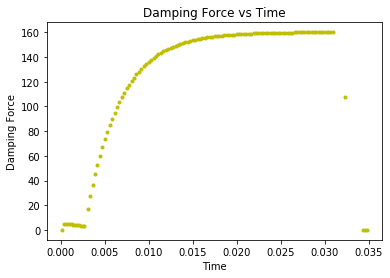

In [15]:
# Damping Force
plt.axes()
Time = 0
for n in range(1,Nodes):
    damping_force = model.Damping.value*model.dx1[n].value
    time = model.h[n].value
    Time += time
    #print(Time)
    #print(force)
    plt.plot(Time,damping_force,'y.')
    plt.xlabel('Time')
    plt.ylabel('Damping Force')
    plt.title('Damping Force vs Time')

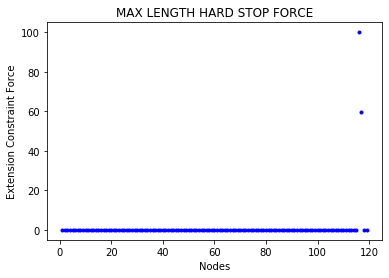

In [16]:
# Extension Constraint Force
plt.axes()
Time = 0
for n in range(1,Nodes):
    ext_force = model.CF_ext[n].value
    time = model.h[n].value
    Time += time
    
    plt.plot(n,ext_force,'b.')
    plt.xlabel('Nodes')
    plt.ylabel('Extension Constraint Force')
    plt.title('MAX LENGTH HARD STOP FORCE')

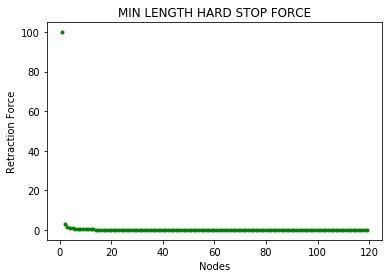

In [17]:
# Retraction Constraint Force  
plt.axes()  
Time = 0
for n in range(1,Nodes):
    rtn_force = model.CF_rtn[n].value
    time = model.h[n].value
    Time += time
    
    plt.plot(n,rtn_force, 'g.')
    plt.xlabel('Nodes')
    plt.ylabel('Retraction Force')
    plt.title('MIN LENGTH HARD STOP FORCE')

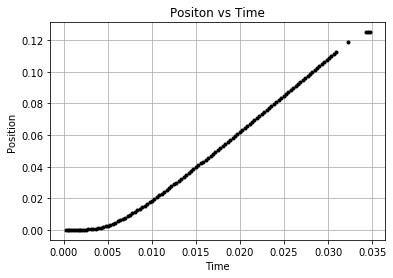

In [18]:
# Position vs Time
plt.axes()
plt.grid(True)
Time = 0    
for n in range(1,Nodes):
    position = model.x1[n].value
    time = model.h[n].value
    Time += time
    
    plt.plot(Time,position,'k.')
    plt.xlabel('Time')
    plt.ylabel('Position')
    plt.title('Positon vs Time')
#plt.savefig('Position.png')

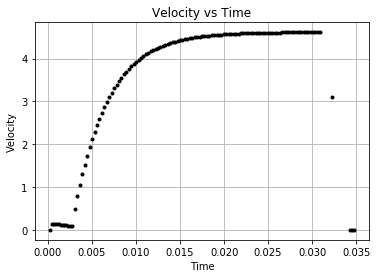

In [19]:
#Velocity vs Time
plt.axes()
Time = 0
plt.grid(True)
for n in range(1,Nodes):
    velocity = model.dx1[n].value
    time = model.h[n].value
    Time += time
    
    plt.plot(Time,velocity,'k.')
    plt.xlabel('Time')
    plt.ylabel('Velocity')
    plt.title('Velocity vs Time')
#plt.savefig('Velocity.png')

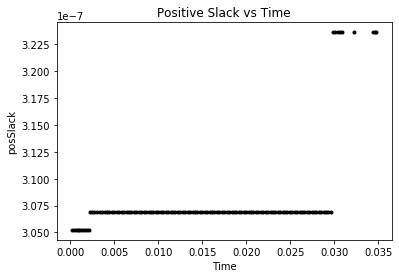

In [20]:
# Positive Slack
plt.axes()
Time = 0
for n in range (1,Nodes):
    posSlack = model.CF_pos[n].value
    time = model.h[n].value
    Time += time
    
    plt.plot(Time,posSlack,'k.')
    plt.xlabel('Time')
    plt.ylabel('posSlack')
    plt.title('Positive Slack vs Time')

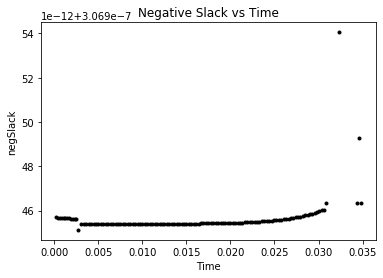

In [21]:
# Negative Slack
plt.axes()
Time = 0
for n in range (1,Nodes):
    negSlack = model.CF_neg[n].value
    time = model.h[n].value
    Time += time
    
    plt.plot(Time,negSlack,'k.')
    plt.xlabel('Time')
    plt.ylabel('negSlack')
    plt.title('Negative Slack vs Time')

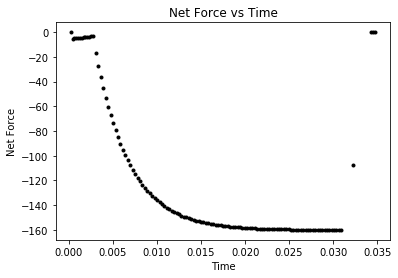

In [22]:
# Net Force
plt.axes()
Time = 0
for n in range (1,Nodes):
    force = model.CF_pos[n].value-model.CF_neg[n].value-model.Damping*model.dx1[n].value
    time = model.h[n].value
    Time += time
    
    plt.plot(Time,force,'k.')
    plt.xlabel('Time')
    plt.ylabel('Net Force')
    plt.title('Net Force vs Time')

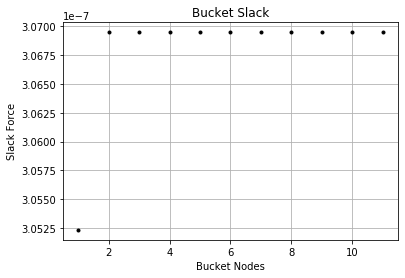

In [23]:
# Positive bucket Slack
plt.axes()
plt.grid(True)
Time = 0
for n in range (1,kNodes):
    #posSlack = model.slackBangPos[n].value
    posSlack = model.kSlack[n].value
    time = model.h[n].value
    Time += time
    
    plt.plot(n,posSlack,'k.')
    plt.xlabel('Bucket Nodes')
    plt.ylabel('Slack Force')
    plt.title('Bucket Slack')